# Metadata

```
Course: DS 5001
Semester Project
Topic: Gilmore Girls
Author: Alice Bogdan
Computing id: ucn3qn
```

Purpose: Using ETA on Gilmore Girls tv scripts. Preprocess the data

In [395]:
# import requests
# from lxml import etree
# import pandas as pd
# import numpy as np
# from io import StringIO
# from glob import glob
# import re

# series_id = 22
# outdir = './dump'
# base_url = "https://transcripts.foreverdreaming.org"

# parser = etree.HTMLParser()

# def get_pages(series_id, offset=0, outdir=''):
#     src_url = f"{base_url}/viewforum.php?f={series_id}&start={offset}"
#     r = requests.get(src_url)
#     tree = etree.parse(StringIO(r.text), parser)
#     page_urls = [f"{base_url}/{path[2:]}" for path in tree.xpath('//a[@class="topictitle"]/@href')]
#     for page_url in page_urls:
#         f, t, sid = page_url.split('?')[-1].split('&')
#         page_r = requests.get(page_url)
#         out_file_name = f"f{f.split('=')[-1]}-r{t.split('=')[-1]}.html"
#         with open(f"{outdir}/{out_file_name}", 'w') as out:
#             out.write(page_r.text)

# for offset in range(0, 175, 25):
#     print(offset)
#     get_pages(22, offset, outdir)

# xpaths = {
#        'title': "//div[@class='boxheading']/h2/text()",
#         'time': "//time/@datetime",
#         'content': "//div[@class='postbody']/p/text()"
# }

# data = []
# for page in glob(f"{outdir}/*.html"):
#     tree = etree.parse(page, parser)
#     title = tree.xpath(xpaths['title'])[0]
#     time = tree.xpath(xpaths['time'])[0]
#     lines = tree.xpath(xpaths['content'])    
#     for i, line in enumerate(lines):
#         data.append((title, time, i, line))
# df = pd.DataFrame(data, columns=['title_raw','time_raw','line_num','doc_raw'])

# df.to_csv(f'{data_home}/output/{data_prefix}.csv')

# Set Up

In [521]:
#libraries
import pandas as pd
import numpy as np
import nltk
# from sklearn.decomposition import PCA
from scipy.linalg import norm
import plotly.express as px
import seaborn as sns; sns.set()
import re

In [397]:
#nltk.download('stopwords')

In [522]:
import os
import sys

# Outputs from this Notebook

In [523]:
data_home = "data"
data_prefix = 'Gilmore_Girls'

In [524]:
# DATA = pd.read_csv(f"{data_home}/output/{data_prefix}-DATA.csv")
# CORPUS = pd.read_csv(f"{data_home}/output/{data_prefix}-TOKENS.csv") #aka the CORPUS
# VOCAB = pd.read_csv(f"{data_home}/output/{data_prefix}-VOCAB.csv")

# Load Data

In [525]:
#import data
DATA = pd.read_csv(f"{data_home}/output/{data_prefix}.csv")

In [526]:
#split title_raw into three columns: Season, Episode, and Title
DATA[['Season', 'Title']] = DATA['title_raw'].str.split('-', n = 1, expand = True)
DATA[['Season', 'Episode']] = DATA['Season'].str.split('x', n = 1, expand = True)

In [527]:
#remove whitespace
DATA['Episode'] = DATA['Episode'].str.strip()
DATA['Season'] = DATA['Season'].str.strip()

In [528]:
#subset data to remove Unamed: 0 and title_raw
DATA = DATA[["Season", "Episode", "Title","time_raw","line_num","doc_raw"]]

need to:
cut by scene
get rid of anything in [] or ()
capture names starts with all caps followed : 

In [529]:
#keep only seasons 1-7 (season 8 is an exception)
DATA = DATA[DATA['Season'].isin(['01', '02', '03', '04', '05', '06', '07'])]
DATA = DATA.sort_values(['Season', 'Episode'])

In [530]:
#not every episode has scenes
DATA[DATA['doc_raw'].str.contains("cut to", case = False)][0:25]

,Season,Episode,Title,time_raw,line_num,doc_raw
61833,01,01,The Pilot,2000-10-17T15:42:16Z,80,CUT TO THE INDEPENDENCE INN
61878,01,01,The Pilot,2000-10-17T15:42:16Z,125,CUT TO OUTSIDE
61897,01,01,The Pilot,2000-10-17T15:42:16Z,144,CUT TO CLASSROOM
61906,01,01,The Pilot,2000-10-17T15:42:16Z,153,CUT TO THE INDEPENDENCE INN
61943,01,01,The Pilot,2000-10-17T15:42:16Z,190,CUT TO OUTSIDE
61999,01,01,The Pilot,2000-10-17T15:42:16Z,246,CUT TO INDEPENDENCE INN KITCHEN
62059,01,01,The Pilot,2000-10-17T15:42:16Z,306,CUT TO INDEPENDENCE INN LOBBY
62069,01,01,The Pilot,2000-10-17T15:42:16Z,316,CUT TO LORELAI'S HOUSE
62072,01,01,The Pilot,2000-10-17T15:42:16Z,319,CUT TO LORELAI'S FRONT PORCH
62121,01,01,The Pilot,2000-10-17T15:42:16Z,368,CUT TO ELDER GILMORE RESIDENCE


# Preprocessing

Output data has been saved and can be uploaded

## Remove stage directions

In [531]:
#regex to capture lines beginning and ending with [] or () indicating stage directions
stage_dir = r"(\(.*\))|(\[.*\])"

In [532]:
#COPY = DATA.copy()

In [533]:
#run regex code to find lines with stage directions
stage_lines = DATA.doc_raw.str.match(stage_dir, case=False) # Returns a truth vector

In [534]:
#remove stage direction lines
DATA = DATA.loc[-stage_lines]

In [535]:
#remove stage directions found within lines
DATA['doc_raw'] = DATA['doc_raw'].replace(regex = stage_dir, value='')

In [536]:
DATA

,Season,Episode,Title,time_raw,line_num,doc_raw
61753,01,01,The Pilot,2000-10-17T15:42:16Z,0,1.01 - Pilot
61754,01,01,The Pilot,2000-10-17T15:42:16Z,1,written by Amy Sherman-Palladino
61755,01,01,The Pilot,2000-10-17T15:42:16Z,2,directed by Lesli Linka Glatter
61756,01,01,The Pilot,2000-10-17T15:42:16Z,3,OPEN IN STARS HOLLOW
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,"LORELAI: Please, Luke. Please, please, please."
...,...,...,...,...,...,...
100866,07,22,Bon Voyage,2007-05-27T10:54:44Z,808,LORELAI: Well how will people know you're the ...
100867,07,22,Bon Voyage,2007-05-27T10:54:44Z,809,RORY: I don't know.
100868,07,22,Bon Voyage,2007-05-27T10:54:44Z,810,LORELAI: I guess they'll just have to read you...
100869,07,22,Bon Voyage,2007-05-27T10:54:44Z,811,RORY: I guess so.


## Capture Characters

In [537]:
#regex to capture characters (example, "RORY:"")
#char_pat = r"^[A-Z]*.? ?:" #does not capture MRS. KIM:
char_pat = r"^[A-Z]*\.?\s?[A-Z]*:" #captures MRS. KIM:

In [538]:
#find all lines that begin with character talking
char_lines = DATA.doc_raw.str.match(char_pat, case=False) # Returns a truth vector

In [539]:
#filter data for only lines where characters talk
#this also removes fluff lines such as the director, episode number, "OPEN IN", "THE END", etc
DATA = DATA.loc[char_lines]

In [540]:
DATA

,Season,Episode,Title,time_raw,line_num,doc_raw
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,"LORELAI: Please, Luke. Please, please, please."
61759,01,01,The Pilot,2000-10-17T15:42:16Z,6,LUKE: How many cups have you had this morning?
61760,01,01,The Pilot,2000-10-17T15:42:16Z,7,LORELAI: None.
61761,01,01,The Pilot,2000-10-17T15:42:16Z,8,LUKE: Plus...
61762,01,01,The Pilot,2000-10-17T15:42:16Z,9,"LORELAI: Five, but yours is better."
...,...,...,...,...,...,...
100865,07,22,Bon Voyage,2007-05-27T10:54:44Z,807,RORY: Well It wasn't very flattering.
100866,07,22,Bon Voyage,2007-05-27T10:54:44Z,808,LORELAI: Well how will people know you're the ...
100867,07,22,Bon Voyage,2007-05-27T10:54:44Z,809,RORY: I don't know.
100868,07,22,Bon Voyage,2007-05-27T10:54:44Z,810,LORELAI: I guess they'll just have to read you...


## Split doc_raw to form column for characters

In [541]:
DATA[['Character', 'lines']] = DATA['doc_raw'].str.split(':', n = 1, expand = True)

/Users/alicebogdan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [542]:
DATA = DATA[["Season","Episode","Title","time_raw","line_num","Character","lines"]]

In [543]:
DATA

,Season,Episode,Title,time_raw,line_num,Character,lines
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,LORELAI,"Please, Luke. Please, please, please."
61759,01,01,The Pilot,2000-10-17T15:42:16Z,6,LUKE,How many cups have you had this morning?
61760,01,01,The Pilot,2000-10-17T15:42:16Z,7,LORELAI,None.
61761,01,01,The Pilot,2000-10-17T15:42:16Z,8,LUKE,Plus...
61762,01,01,The Pilot,2000-10-17T15:42:16Z,9,LORELAI,"Five, but yours is better."
...,...,...,...,...,...,...,...
100865,07,22,Bon Voyage,2007-05-27T10:54:44Z,807,RORY,Well It wasn't very flattering.
100866,07,22,Bon Voyage,2007-05-27T10:54:44Z,808,LORELAI,Well how will people know you're the world's ...
100867,07,22,Bon Voyage,2007-05-27T10:54:44Z,809,RORY,I don't know.
100868,07,22,Bon Voyage,2007-05-27T10:54:44Z,810,LORELAI,I guess they'll just have to read your stuff.


In [544]:
DATA['Character'] = DATA['Character'].str.strip()
DATA['Character'] = DATA['Character'].str.upper()

<ipython-input-544-d8d10a87a192>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA['Character'] = DATA['Character'].str.strip()
<ipython-input-544-d8d10a87a192>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA['Character'] = DATA['Character'].str.upper()


In [545]:
DATA['Character'].sort_values().unique()

array(['', 'ADVISOR', 'AK', 'ALAN', 'ALEX', 'ALEXANDRA', 'ALISON', 'ALL',
       'ALTHEA', 'AMIR', 'ANDRE', 'ANDREA', 'ANDREW', 'ANDY', 'ANN',
       'ANNA', 'ANNABELLE', 'ANNOUNCER', 'ANOTHER MAN',
       'ANSWERING MACHINE', 'ANTONIA', 'APRIL', 'ARLETTA', 'ARTHUR',
       'ASHER', 'ASIAN CAESAR', 'ATTENDANT', 'AUBREY', 'AUCTIONEER',
       'AUDREY', 'AUNT JUN', 'AURORA', 'AVA', 'AYOR', 'BABETE', 'BABETTE',
       'BAND', 'BAND TEACHER', 'BARBARA', 'BARBETTE', 'BARRY',
       'BARTENDER', 'BEARDED CUSTOMER', 'BEATRICE', 'BEAU', 'BELLBOY',
       'BEN', 'BENNY', 'BERT', 'BEVERLY', 'BIKE GUY', 'BIKER', 'BIKERS',
       'BILL', 'BILLY', 'BING CROSBY', 'BOB', 'BOBBI', 'BOBBY', 'BONNIE',
       'BOOTSY', 'BOOZOO', 'BOTH', 'BOUNCER', 'BOY', 'BOYS', 'BRAD',
       'BRADLEY', 'BRAIN', 'BRANDON', 'BREAD GUY', 'BRENNON', 'BRIAN',
       'BRIDE', 'BRUCE', 'BRUNETTE', 'BUDDY', 'BUTCHER', 'CAESAR',
       'CAESER', 'CAITLYN', 'CARL', 'CAROL', 'CAROLE', 'CAROLINE',
       'CAROLYN', 'CARRIE', 'CARY

In [546]:
DATA[DATA['Character'] == "MADONNA LOUISE"]

,Season,Episode,Title,time_raw,line_num,Character,lines
126936,05,03,Written in the Stars,2004-10-17T05:28:49Z,47,MADONNA LOUISE,Dinner is served in the main house.
126939,05,03,Written in the Stars,2004-10-17T05:28:49Z,50,MADONNA LOUISE,But the madam is ready now.
127073,05,03,Written in the Stars,2004-10-17T05:28:49Z,184,MADONNA LOUISE,I told his valet about it.
127075,05,03,Written in the Stars,2004-10-17T05:28:49Z,186,MADONNA LOUISE,"Yes, Mrs. Gilmore."
127568,05,03,Written in the Stars,2004-10-17T05:28:49Z,679,MADONNA LOUISE,"Can I get you some dessert, Mrs. Gilmore?"
127570,05,03,Written in the Stars,2004-10-17T05:28:49Z,681,MADONNA LOUISE,"Very good, Mrs. Gilmore."
127572,05,03,Written in the Stars,2004-10-17T05:28:49Z,683,MADONNA LOUISE,"I won't, Mrs. Gilmore."
127574,05,03,Written in the Stars,2004-10-17T05:28:49Z,685,MADONNA LOUISE,I sprayed for ants this afternoon.
127576,05,03,Written in the Stars,2004-10-17T05:28:49Z,687,MADONNA LOUISE,I know Mrs. Gilmore.
127578,05,03,Written in the Stars,2004-10-17T05:28:49Z,689,MADONNA LOUISE,"Okay, Mrs. Gilmore."


In [547]:
#remove directed by lines
DATA = DATA[DATA['Character'] != "DIRECTED BY"]
DATA = DATA[DATA['Character'] != "WRITTEN BY"]
DATA = DATA[DATA['Character'] != "OFF SCREEN"]

In [548]:
DATA

,Season,Episode,Title,time_raw,line_num,Character,lines
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,LORELAI,"Please, Luke. Please, please, please."
61759,01,01,The Pilot,2000-10-17T15:42:16Z,6,LUKE,How many cups have you had this morning?
61760,01,01,The Pilot,2000-10-17T15:42:16Z,7,LORELAI,None.
61761,01,01,The Pilot,2000-10-17T15:42:16Z,8,LUKE,Plus...
61762,01,01,The Pilot,2000-10-17T15:42:16Z,9,LORELAI,"Five, but yours is better."
...,...,...,...,...,...,...,...
100865,07,22,Bon Voyage,2007-05-27T10:54:44Z,807,RORY,Well It wasn't very flattering.
100866,07,22,Bon Voyage,2007-05-27T10:54:44Z,808,LORELAI,Well how will people know you're the world's ...
100867,07,22,Bon Voyage,2007-05-27T10:54:44Z,809,RORY,I don't know.
100868,07,22,Bon Voyage,2007-05-27T10:54:44Z,810,LORELAI,I guess they'll just have to read your stuff.


In [549]:
#it's Rory
DATA[DATA['Character'] == ""]

,Season,Episode,Title,time_raw,line_num,Character,lines
17465,01,20,P.S. I Lo...,2001-05-15T14:32:16Z,782,,Please.


In [550]:
DATA['Episode'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22'],
      dtype=object)

In [551]:
#incorrect names lists
lorelai_sp = ['LOREAI', 'LOREALI', 'LORELA', 'LORELAIL', 'LORELI', 'LORLAI', 'LORLEAI', 'LORLELAI', 'L','ORELAI']
luke_sp = ['LUK','FILM LUKE']
rory_sp = ['R',"",'ORY']
richard_sp = ['RICHRAD','GRANDPA']
emily_sp = ['EMIL','GRANDMOTHER','GRANDMA','RMILY','EMILY VOICE']
sookie_sp = ['SOOKEI', 'SOOKI', 'SOOKIES']
caesar_sp = ['CAESER']
christopher_sp = ['CHRISTOHPER','CHRISTOPER','CHRSTOPHER','CHRISTOPER','CHRIS']
lindsay_sp = ['LINDAY','LINDSAY VOICE'] #dean's wife
headmaster_sp = ['CHARLESTON','HDM. CHARLESTON']
babette_sp = ['BABETE','BARBETTE']
logan_sp = ['LOG']
trix_sp = ['GRAN'] #Lorelai the first
michel_sp = ['MICHE','MICHELL']
tristin_sp = ['TRISTAN','MR. DUGRAY']
troubadour_sp = ['TROUBADOR']
tanna_sp = ['TANA'] #Rory's college roommate
prof_sp = ['PROFERSSOR']
brian_sp = ['BRAIN'] #band member
taylor_sp = ['TAYOR']
mrs_kim_sp = ['MRS. KIM','MRS KIM']
patty_sp = ['MISS PATTY']
max_sp = ['MR. MEDINA']
rev_skinner_sp = ['REV.SKINNER']

In [552]:
#replace incorrect names with correct names
DATA['Character'] = DATA['Character'].replace(lorelai_sp, value = 'LORELAI')
DATA['Character'] = DATA['Character'].replace(luke_sp, value = 'LUKE')
DATA['Character'] = DATA['Character'].replace(rory_sp, value = 'RORY')
DATA['Character'] = DATA['Character'].replace(richard_sp, value = 'RICHARD')
DATA['Character'] = DATA['Character'].replace(emily_sp, value = 'EMILY')
DATA['Character'] = DATA['Character'].replace(sookie_sp, value = 'SOOKIE')
DATA['Character'] = DATA['Character'].replace(caesar_sp, value = 'CAESAR')
DATA['Character'] = DATA['Character'].replace(christopher_sp, value = 'CHRISTOPHER')
DATA['Character'] = DATA['Character'].replace(lindsay_sp, value = 'LINDSAY')
DATA['Character'] = DATA['Character'].replace(headmaster_sp, value = 'HEADMASTER')
DATA['Character'] = DATA['Character'].replace(babette_sp, value = 'BABETTE')
DATA['Character'] = DATA['Character'].replace(logan_sp, value = 'LOGAN')
DATA['Character'] = DATA['Character'].replace(trix_sp, value = 'TRIX')
DATA['Character'] = DATA['Character'].replace(michel_sp, value = 'MICHEL')
DATA['Character'] = DATA['Character'].replace(tristin_sp, value = 'TRISTIN')
DATA['Character'] = DATA['Character'].replace(troubadour_sp, value = 'TROUBADOUR')
DATA['Character'] = DATA['Character'].replace(tanna_sp, value = 'TANNA')
DATA['Character'] = DATA['Character'].replace(prof_sp, value = 'PROFESSOR')
DATA['Character'] = DATA['Character'].replace(brian_sp, value = 'BRIAN')
DATA['Character'] = DATA['Character'].replace(taylor_sp, value = 'TAYLOR')
DATA['Character'] = DATA['Character'].replace(mrs_kim_sp, value = 'MRS.KIM')
DATA['Character'] = DATA['Character'].replace(patty_sp, value = 'PATTY')
DATA['Character'] = DATA['Character'].replace(max_sp, value = 'MAX')
DATA['Character'] = DATA['Character'].replace(rev_skinner_sp, value = 'REVEREND SKINNER')


In [553]:
DATA['Character'].sort_values().unique()

array(['ADVISOR', 'AK', 'ALAN', 'ALEX', 'ALEXANDRA', 'ALISON', 'ALL',
       'ALTHEA', 'AMIR', 'ANDRE', 'ANDREA', 'ANDREW', 'ANDY', 'ANN',
       'ANNA', 'ANNABELLE', 'ANNOUNCER', 'ANOTHER MAN',
       'ANSWERING MACHINE', 'ANTONIA', 'APRIL', 'ARLETTA', 'ARTHUR',
       'ASHER', 'ASIAN CAESAR', 'ATTENDANT', 'AUBREY', 'AUCTIONEER',
       'AUDREY', 'AUNT JUN', 'AURORA', 'AVA', 'AYOR', 'BABETTE', 'BAND',
       'BAND TEACHER', 'BARBARA', 'BARRY', 'BARTENDER',
       'BEARDED CUSTOMER', 'BEATRICE', 'BEAU', 'BELLBOY', 'BEN', 'BENNY',
       'BERT', 'BEVERLY', 'BIKE GUY', 'BIKER', 'BIKERS', 'BILL', 'BILLY',
       'BING CROSBY', 'BOB', 'BOBBI', 'BOBBY', 'BONNIE', 'BOOTSY',
       'BOOZOO', 'BOTH', 'BOUNCER', 'BOY', 'BOYS', 'BRAD', 'BRADLEY',
       'BRANDON', 'BREAD GUY', 'BRENNON', 'BRIAN', 'BRIDE', 'BRUCE',
       'BRUNETTE', 'BUDDY', 'BUTCHER', 'CAESAR', 'CAITLYN', 'CARL',
       'CAROL', 'CAROLE', 'CAROLINE', 'CAROLYN', 'CARRIE', 'CARY GRANT',
       'CASHIER', 'CATHERINE', 'CELINE', 'C

In [554]:
DATA[DATA['Character'] == 'MRS SINCLAIR']

,Season,Episode,Title,time_raw,line_num,Character,lines
21332,07,18,Hay Bale Maze,2007-04-29T13:18:09Z,159,MRS SINCLAIR,We've been dreaming about the festival since ...
21336,07,18,Hay Bale Maze,2007-04-29T13:18:09Z,163,MRS SINCLAIR,He did. I had to get my hair dryer and an ext...
21845,07,18,Hay Bale Maze,2007-04-29T13:18:09Z,672,MRS SINCLAIR,"I don't think so sweetie it's just a maze, bu..."
21859,07,18,Hay Bale Maze,2007-04-29T13:18:09Z,686,MRS SINCLAIR,"Co o on, let's go!"


In [555]:
#extract year
DATA['Year'] = DATA.time_raw.str.split('-', n = 1, expand = True)[0]

In [556]:
DATA

,Season,Episode,Title,time_raw,line_num,Character,lines,Year
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,LORELAI,"Please, Luke. Please, please, please.",2000
61759,01,01,The Pilot,2000-10-17T15:42:16Z,6,LUKE,How many cups have you had this morning?,2000
61760,01,01,The Pilot,2000-10-17T15:42:16Z,7,LORELAI,None.,2000
61761,01,01,The Pilot,2000-10-17T15:42:16Z,8,LUKE,Plus...,2000
61762,01,01,The Pilot,2000-10-17T15:42:16Z,9,LORELAI,"Five, but yours is better.",2000
...,...,...,...,...,...,...,...,...
100865,07,22,Bon Voyage,2007-05-27T10:54:44Z,807,RORY,Well It wasn't very flattering.,2007
100866,07,22,Bon Voyage,2007-05-27T10:54:44Z,808,LORELAI,Well how will people know you're the world's ...,2007
100867,07,22,Bon Voyage,2007-05-27T10:54:44Z,809,RORY,I don't know.,2007
100868,07,22,Bon Voyage,2007-05-27T10:54:44Z,810,LORELAI,I guess they'll just have to read your stuff.,2007


In [557]:
#save to csv
DATA.to_csv(f'{data_home}/output/{data_prefix}-DATA.csv')

In [558]:
DATA

,Season,Episode,Title,time_raw,line_num,Character,lines,Year
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,LORELAI,"Please, Luke. Please, please, please.",2000
61759,01,01,The Pilot,2000-10-17T15:42:16Z,6,LUKE,How many cups have you had this morning?,2000
61760,01,01,The Pilot,2000-10-17T15:42:16Z,7,LORELAI,None.,2000
61761,01,01,The Pilot,2000-10-17T15:42:16Z,8,LUKE,Plus...,2000
61762,01,01,The Pilot,2000-10-17T15:42:16Z,9,LORELAI,"Five, but yours is better.",2000
...,...,...,...,...,...,...,...,...
100865,07,22,Bon Voyage,2007-05-27T10:54:44Z,807,RORY,Well It wasn't very flattering.,2007
100866,07,22,Bon Voyage,2007-05-27T10:54:44Z,808,LORELAI,Well how will people know you're the world's ...,2007
100867,07,22,Bon Voyage,2007-05-27T10:54:44Z,809,RORY,I don't know.,2007
100868,07,22,Bon Voyage,2007-05-27T10:54:44Z,810,LORELAI,I guess they'll just have to read your stuff.,2007


# Create LIB

## LIB by Season

In [559]:
LIB = DATA.copy()

In [560]:
#add show title
LIB['Show'] = 'Gilmore Girls'

In [561]:
#subset data
LIB = LIB[['Show','Season','Episode','Title','Year','line_num','Character','lines']]

In [562]:
#count the number of epsiodes per season
LIB['Num_Episodes'] = LIB.groupby(['Season'])['Episode'].transform('nunique')
#count the number of lines per season
LIB['Num_Lines'] = LIB.groupby('Season')['Season'].transform('count')

In [563]:
#separate library
LIB2 = LIB.copy()

In [564]:
#subset to the number of seasons in the show
LIB = LIB.drop_duplicates(['Season'])

In [565]:
#subset data
LIB = LIB[['Show','Season','Num_Episodes','Year','Num_Lines']]

In [566]:
#reset index
LIB = LIB.reset_index(drop = True).set_index('Show')

In [567]:
LIB

,Season,Num_Episodes,Year,Num_Lines
Show,,,,
Gilmore Girls,01,21,2000,16031
Gilmore Girls,02,22,2001,18264
Gilmore Girls,03,22,2002,17699
Gilmore Girls,04,22,2003,17806
Gilmore Girls,05,22,2004,16737
Gilmore Girls,06,22,2005,16145
Gilmore Girls,07,22,2006,15188


In [568]:
#save output
LIB.to_csv(f'{data_home}/output/{data_prefix}-LIB-SEASON.csv')

## LIB by Episode

In [569]:
#count the number of lines per season and episode
LIB2['Num_Lines_per_Episode'] = LIB2.groupby(['Season','Episode'])['Season'].transform('count')

In [570]:
#unique episodes
LIB2 = LIB2.drop_duplicates(['Title'])

In [571]:
#subset the data
LIB2 = LIB2[['Show','Season','Num_Episodes','Episode','Title','Year','Num_Lines_per_Episode']]

In [572]:
#reset index
LIB2 = LIB2.reset_index(drop = True).set_index('Show')

In [573]:
#rename column
LIB2.rename(columns={"Num_Episodes":"Num_Episodes_per_Season"}, inplace=True)

In [574]:
LIB2

,Season,Num_Episodes_per_Season,Episode,Title,Year,Num_Lines_per_Episode
Show,,,,,,
Gilmore Girls,01,21,01,The Pilot,2000,630
Gilmore Girls,01,21,02,The Lorelai's First Day at Chilton,2000,586
Gilmore Girls,01,21,03,k*ll Me Now,2000,698
Gilmore Girls,01,21,04,The Deer Hunters,2000,717
Gilmore Girls,01,21,05,Rory's Birthday Parties,2000,753
...,...,...,...,...,...,...
Gilmore Girls,07,22,18,Hay Bale Maze,2007,753
Gilmore Girls,07,22,19,It's Just Like Riding A Bike,2007,791
Gilmore Girls,07,22,20,Lorelai? Lorelai?,2007,699


In [575]:
#save output
LIB2.to_csv(f'{data_home}/output/{data_prefix}-LIB-EPISODE.csv')

# Token Table

In [576]:
DATA.head()

,Season,Episode,Title,time_raw,line_num,Character,lines,Year
61758,01,01,The Pilot,2000-10-17T15:42:16Z,5,LORELAI,"Please, Luke. Please, please, please.",2000
61759,01,01,The Pilot,2000-10-17T15:42:16Z,6,LUKE,How many cups have you had this morning?,2000
61760,01,01,The Pilot,2000-10-17T15:42:16Z,7,LORELAI,None.,2000
61761,01,01,The Pilot,2000-10-17T15:42:16Z,8,LUKE,Plus...,2000
61762,01,01,The Pilot,2000-10-17T15:42:16Z,9,LORELAI,"Five, but yours is better.",2000


In [577]:
OHCO = ['Season','Episode','line_num','Character','sent_num','token_num']

In [578]:
SEAS = OHCO[:1]
EPI = OHCO[:2]
LINE = OHCO[:3]
CHAR = OHCO[:4]
SENT = OHCO[:5]
TOKEN = OHCO[:6]

In [579]:
GG = DATA[['Season','Episode','line_num','Character','lines']]

In [456]:
#GG['lines'] = GG['lines'].str.strip()

In [580]:
#SEASONS = GG.set_index(SEAS)
#EPISODES = GG.set_index(EPI)
#CHARACTERS = GG.set_index(CHAR)
CHARACTERS = GG.set_index(CHAR)
#SENT = GG.set_index(SENT)
#TOKENS2 = GG.set_index(TOKEN)

In [581]:
CHARACTERS

lines
Season Episode line_num Character                                                   
01     01      5        LORELAI               Please, Luke. Please, please, please. 
               6        LUKE               How many cups have you had this morning? 
               7        LORELAI                                               None. 
               8        LUKE                                                Plus... 
               9        LORELAI                          Five, but yours is better. 
...                                                                              ...
07     22      807      RORY                         Well It wasn't very flattering.
               808      LORELAI     Well how will people know you're the world's ...
               809      RORY                                           I don't know.
               810      LORELAI        I guess they'll just have to read your stuff.
               811      RORY                                             I guess so.

[117870 rows x 1 columns]

## Split lines into sentences

In [582]:
#split lines into sentences
sent_pat = r'[.?!;:]+'
SENTS = CHARACTERS['lines'].str.split(sent_pat, expand=True).stack()\
    .to_frame('sent_str')
SENTS.index.names = SENT

In [583]:
SENTS

sent_str
Season Episode line_num Character sent_num                                               
01     01      5        LORELAI   0                                          Please, Luke
                                  1                                Please, please, please
                                  2                                                      
               6        LUKE      0               How many cups have you had this morning
                                  1                                                      
...                                                                                   ...
07     22      809      RORY      1                                                      
               810      LORELAI   0          I guess they'll just have to read your stuff
                                  1                                                      
               811      RORY      0                                            I guess so
                                  1                                                      

[298012 rows x 1 columns]

In [461]:
# SENTS = CHARACTERS.lines.apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
#         .stack()\
#         .to_frame('sent_str')
# SENTS.index.names = OHCO[:5]

In [462]:
# SENTS

In [584]:
SENTS = SENTS[~SENTS['sent_str'].str.match(r'^\s*$')] # Remove empty paragraphs
SENTS.sent_str = SENTS.sent_str.str.strip() # CRUCIAL TO REMOVE BLANK TOKENS

/Users/alicebogdan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [585]:
SENTS

sent_str
Season Episode line_num Character sent_num                                                   
01     01      5        LORELAI   0                                              Please, Luke
                                  1                                    Please, please, please
               6        LUKE      0                   How many cups have you had this morning
               7        LORELAI   0                                                      None
               8        LUKE      0                                                      Plus
...                                                                                       ...
07     22      807      RORY      0                            Well It wasn't very flattering
               808      LORELAI   0         Well how will people know you're the world's g...
               809      RORY      0                                              I don't know
               810      LORELAI   0              I guess they'll just have to read your stuff
               811      RORY      0                                                I guess so

[180023 rows x 1 columns]

## Split sentences into tokens

In [465]:
#split by spaces, single quotes, commas, and dashes
# token_pat = r"[\s',-]+"
# TOKENS = SENTS['sent_str'].str.split(token_pat, expand=True).stack()\
#     .to_frame('token_str')
# TOKENS.index.names = SENT

In [586]:
#add "'" *apostrophe to remove cases like "lukes". Will convert to "luke" and "s"
token_pat = r"[\s,-]+"
TOKENS = SENTS['sent_str'].str.split(token_pat, expand=True).stack()\
    .to_frame('token_str')
TOKENS.index.names = TOKEN

In [587]:
TOKENS.head()

token_str
Season Episode line_num Character sent_num token_num          
01     01      5        LORELAI   0        0            Please
                                           1              Luke
                                  1        0            Please
                                           1            please
                                           2            please

In [588]:
TOKENS = TOKENS[TOKENS.token_str != '']

In [589]:
TOKENS

token_str
Season Episode line_num Character sent_num token_num          
01     01      5        LORELAI   0        0            Please
                                           1              Luke
                                  1        0            Please
                                           1            please
                                           2            please
...                                                        ...
07     22      810      LORELAI   0        7              your
                                           8             stuff
               811      RORY      0        0                 I
                                           1             guess
                                           2                so

[1097220 rows x 1 columns]

In [590]:
# Sentences to Tokens
# Local function to pick tokenizer
def word_tokenize(x):
    if ws:
        s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
    else:
        s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x)))
    return s

In [591]:
#whitespace variable
ws = True

In [592]:
#TEST_T = TOKENS.copy()

In [593]:
#add POS as tuple (word, POS)
TOKENS = TOKENS.token_str.apply(word_tokenize).stack().to_frame().rename(columns = {0:'pos_tuple'})

In [600]:
TOKENS = TOKENS.reset_index()
TOKENS = TOKENS[['Season','Episode','line_num','Character','sent_num','token_num','pos_tuple']]

TOKENS = TOKENS.set_index(TOKEN)
TOKENS

pos_tuple
Season Episode line_num Character sent_num token_num              
01     01      5        LORELAI   0        0          (Please, VB)
                                           1            (Luke, NN)
                                  1        0          (Please, VB)
                                           1          (please, NN)
                                           2          (please, NN)
...                                                            ...
07     22      810      LORELAI   0        7          (your, PRP$)
                                           8           (stuff, NN)
               811      RORY      0        0              (I, PRP)
                                           1           (guess, NN)
                                           2              (so, RB)

[1097220 rows x 1 columns]

In [601]:
#isolate POS
TOKENS['pos'] = TOKENS.pos_tuple.apply(lambda x: x[1])
#isolate token from pos_tuple
TOKENS['token_str'] = TOKENS.pos_tuple.apply(lambda x: x[0])

In [602]:
TOKENS.index.names = TOKEN
TOKENS

pos_tuple   pos  \
Season Episode line_num Character sent_num token_num                       
01     01      5        LORELAI   0        0          (Please, VB)    VB   
                                           1            (Luke, NN)    NN   
                                  1        0          (Please, VB)    VB   
                                           1          (please, NN)    NN   
                                           2          (please, NN)    NN   
...                                                            ...   ...   
07     22      810      LORELAI   0        7          (your, PRP$)  PRP$   
                                           8           (stuff, NN)    NN   
               811      RORY      0        0              (I, PRP)   PRP   
                                           1           (guess, NN)    NN   
                                           2              (so, RB)    RB   

                                                     token_str  
Season Episode line_num Character sent_num token_num            
01     01      5        LORELAI   0        0            Please  
                                           1              Luke  
                                  1        0            Please  
                                           1            please  
                                           2            please  
...                                                        ...  
07     22      810      LORELAI   0        7              your  
                                           8             stuff  
               811      RORY      0        0                 I  
                                           1             guess  
                                           2                so  

[1097220 rows x 3 columns]

In [603]:
#save output
TOKENS.to_csv(f'{data_home}/output/{data_prefix}-TOKENS.csv')

## Extract Vocab

In [604]:
#remove non-word characters and replace with blank. Then lowercase all letters
TOKENS['term_str'] = TOKENS.token_str.replace(r'[\W_]+', '', regex=True).str.lower()

In [605]:
TOKENS

pos_tuple   pos  \
Season Episode line_num Character sent_num token_num                       
01     01      5        LORELAI   0        0          (Please, VB)    VB   
                                           1            (Luke, NN)    NN   
                                  1        0          (Please, VB)    VB   
                                           1          (please, NN)    NN   
                                           2          (please, NN)    NN   
...                                                            ...   ...   
07     22      810      LORELAI   0        7          (your, PRP$)  PRP$   
                                           8           (stuff, NN)    NN   
               811      RORY      0        0              (I, PRP)   PRP   
                                           1           (guess, NN)    NN   
                                           2              (so, RB)    RB   

                                                     token_str term_str  
Season Episode line_num Character sent_num token_num                     
01     01      5        LORELAI   0        0            Please   please  
                                           1              Luke     luke  
                                  1        0            Please   please  
                                           1            please   please  
                                           2            please   please  
...                                                        ...      ...  
07     22      810      LORELAI   0        7              your     your  
                                           8             stuff    stuff  
               811      RORY      0        0                 I        i  
                                           1             guess    guess  
                                           2                so       so  

[1097220 rows x 4 columns]

In [606]:
TOKENS.query("term_str == 'lukes'")

pos_tuple pos  \
Season Episode line_num Character sent_num token_num                     
01     01      16       LUKE      0        0          (Luke's, NN)  NN   
       04      781      LORELAI   0        13         (Luke's, NN)  NN   
       07      358      RORY      1        1          (Luke's, NN)  NN   
               455      LORELAI   1        4          (Luke's, NN)  NN   
       08      768      RORY      0        2          (Luke's, NN)  NN   
...                                                            ...  ..   
07     19      299      LORELAI   1        4          (Luke's, NN)  NN   
               778      LUKE      4        4          (Luke's, NN)  NN   
       20      238      LORELAI   1        3          (Luke's, NN)  NN   
               488      LUKE      0        0          (Luke's, NN)  NN   
       22      428      BABETTE   0        14         (Luke's, NN)  NN   

                                                     token_str term_str  
Season Episode line_num Character sent_num token_num                     
01     01      16       LUKE      0        0            Luke's    lukes  
       04      781      LORELAI   0        13           Luke's    lukes  
       07      358      RORY      1        1            Luke's    lukes  
               455      LORELAI   1        4            Luke's    lukes  
       08      768      RORY      0        2            Luke's    lukes  
...                                                        ...      ...  
07     19      299      LORELAI   1        4            Luke's    lukes  
               778      LUKE      4        4            Luke's    lukes  
       20      238      LORELAI   1        3            Luke's    lukes  
               488      LUKE      0        0            Luke's    lukes  
       22      428      BABETTE   0        14           Luke's    lukes  

[279 rows x 4 columns]

In [481]:
TOKENS.query("term_str == 'midgets'")

pos_tuple  pos  \
Season Episode Character line_num sent_num token_num                        
01     03      MICHEL    0        6        0          (midgets, NNS)  NNS   
02     17      SOOKIE    0        2        0          (midgets, NNS)  NNS   
               MICHEL    1        8        0          (midgets, NNS)  NNS   
               LORELAI   0        5        0          (midgets, NNS)  NNS   
               SOOKIE    0        3        0          (midgets, NNS)  NNS   
               LORELAI   1        7        0          (midgets, NNS)  NNS   
               EMILY     0        2        0          (midgets, NNS)  NNS   

                                                     token_str term_str  
Season Episode Character line_num sent_num token_num                     
01     03      MICHEL    0        6        0           midgets  midgets  
02     17      SOOKIE    0        2        0           midgets  midgets  
               MICHEL    1        8        0           midgets  midgets  
               LORELAI   0        5        0           midgets  midgets  
               SOOKIE    0        3        0           midgets  midgets  
               LORELAI   1        7        0           midgets  midgets  
               EMILY     0        2        0           midgets  midgets

In [607]:
#add count
VOCAB = TOKENS.term_str.value_counts().to_frame('n')

In [608]:
VOCAB.head(20)

,n
i,38882
you,38256
the,31072
to,26174
a,23702
and,20591
it,15656
that,12660
of,11992
is,10378


In [609]:
VOCAB.index.name = 'term_str'

Reference for variable names in VOCAB    
n:       count  
n_chars: len of term  
p:       probability  
s:       surpise  
i:       information  
h:       entropy  

In [610]:
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB['n'] / VOCAB['n'].sum()
VOCAB['s'] = 1 / VOCAB['p']
VOCAB['i'] = np.log2(VOCAB['s']) # Same as negative log probability (i.e. log likelihood)
VOCAB['h'] = VOCAB['p'] * VOCAB['i'] 
H = VOCAB['h'].sum()

In [611]:
VOCAB

,n,n_chars,p,s,i,h
term_str,,,,,,
i,38882,1,3.543683e-02,2.821923e+01,4.818607,0.170756
you,38256,3,3.486630e-02,2.868099e+01,4.842023,0.168823
the,31072,3,2.831884e-02,3.531218e+01,5.142094,0.145618
to,26174,2,2.385483e-02,4.192023e+01,5.389575,0.128567
a,23702,1,2.160187e-02,4.629230e+01,5.532700,0.119517
...,...,...,...,...,...,...
practising,1,10,9.113943e-07,1.097220e+06,20.065421,0.000018
wishy,1,5,9.113943e-07,1.097220e+06,20.065421,0.000018
frigging,1,8,9.113943e-07,1.097220e+06,20.065421,0.000018


# Annotate VOCAB

## Get Max POS (Part-of-Speech)

In [612]:
VOCAB['max_pos'] = TOKENS[['term_str','pos']].value_counts().unstack(fill_value = 0).idxmax(1)

In [613]:
VOCAB.head()

,n,n_chars,p,s,i,h,max_pos
term_str,,,,,,,
i,38882,1,0.035437,28.219227,4.818607,0.170756,PRP
you,38256,3,0.034866,28.680991,4.842023,0.168823,PRP
the,31072,3,0.028319,35.312178,5.142094,0.145618,DT
to,26174,2,0.023855,41.920226,5.389575,0.128567,TO
a,23702,1,0.021602,46.292296,5.532700,0.119517,DT


## Compute POS Ambiguity

In [614]:
VOCAB['n_pos'] = TOKENS[['term_str','pos']].value_counts().unstack().count(1)

In [615]:
VOCAB['cat_pos'] = TOKENS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))

In [616]:
VOCAB

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos
term_str,,,,,,,,,
i,38882,1,3.543683e-02,2.821923e+01,4.818607,0.170756,PRP,3,"{NN, PRP, NNS}"
you,38256,3,3.486630e-02,2.868099e+01,4.842023,0.168823,PRP,3,"{NN, PRP, NNS}"
the,31072,3,2.831884e-02,3.531218e+01,5.142094,0.145618,DT,3,"{NN, DT, NNS}"
to,26174,2,2.385483e-02,4.192023e+01,5.389575,0.128567,TO,3,"{TO, NN, NNS}"
a,23702,1,2.160187e-02,4.629230e+01,5.532700,0.119517,DT,3,"{NN, DT, NNS}"
...,...,...,...,...,...,...,...,...,...
practising,1,10,9.113943e-07,1.097220e+06,20.065421,0.000018,VBG,1,{VBG}
wishy,1,5,9.113943e-07,1.097220e+06,20.065421,0.000018,NN,1,{NN}
frigging,1,8,9.113943e-07,1.097220e+06,20.065421,0.000018,VBG,1,{VBG}


## Add Stopwords

In [617]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [618]:
#stop words classified as 1, else 0
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [619]:
VOCAB[VOCAB.stop == 1].sample(10)

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop
term_str,,,,,,,,,,
now,3293,3,0.003001,333.197692,8.380235,0.025151,RB,2,"{NN, RB}",1
he,4807,2,0.004381,228.254629,7.834500,0.034324,PRP,3,"{NN, PRP, NNS}",1
yourself,309,8,0.000282,3550.873786,11.793958,0.003321,PRP,2,"{NN, PRP}",1
after,671,5,0.000612,1635.201192,10.675252,0.006528,IN,2,"{NN, IN}",1
just,7858,4,0.007162,139.630949,7.125475,0.051031,RB,2,"{NN, RB}",1
both,268,4,0.000244,4094.104478,11.999332,0.002931,DT,1,{DT},1
further,17,7,0.000015,64542.352941,15.977959,0.000248,RB,1,{RB},1
themselves,37,10,0.000034,29654.594595,14.855968,0.000501,PRP,1,{PRP},1
there,3493,5,0.003184,314.119668,8.295170,0.026408,RB,4,"{EX, NN, RB, NNS}",1


In [620]:
VOCAB.sample(10)

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop
term_str,,,,,,,,,,
complexion,4,10,3.645577e-06,2.743050e+05,18.065421,0.000066,NN,1,{NN},0
scorsese,1,8,9.113943e-07,1.097220e+06,20.065421,0.000018,JJ,1,{JJ},0
wicker,1,6,9.113943e-07,1.097220e+06,20.065421,0.000018,NN,1,{NN},0
crudités,3,8,2.734183e-06,3.657400e+05,18.480459,0.000051,NN,1,{NN},0
marshmallows,12,12,1.093673e-05,9.143500e+04,16.480459,0.000180,NNS,1,{NNS},0
skillets,1,8,9.113943e-07,1.097220e+06,20.065421,0.000018,NNS,1,{NNS},0
amputation,1,10,9.113943e-07,1.097220e+06,20.065421,0.000018,NN,1,{NN},0
mathematicians,1,14,9.113943e-07,1.097220e+06,20.065421,0.000018,NNS,1,{NNS},0
main,31,4,2.825322e-05,3.539419e+04,15.111225,0.000427,JJ,2,"{NN, JJ}",0


## Stopword Stats

In [621]:
a = VOCAB.groupby('stop').n_chars.mean()
b = VOCAB.groupby('stop').n_pos.mean().sort_values(ascending=False)

In [622]:
pd.concat([a,b],1)

,n_chars,n_pos
stop,,
0,7.076771,1.061264
1,3.808824,1.992647


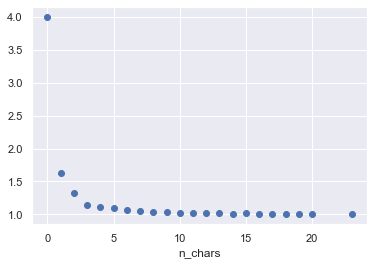

In [623]:
VOCAB.groupby('n_chars').n_pos.mean()\
    .sort_values(ascending=False).plot(style='o');

In [624]:
VOCAB.query('n_chars == "0"')

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop
term_str,,,,,,,,,,
,2599,0,0.002369,422.170065,8.72168,0.020659,NN,4,"{'', NN, CC, NNS}",0


In [625]:
VOCAB[VOCAB.stop == True].sort_values('n_pos', ascending=False)[['n_pos','cat_pos']].head(20)

,n_pos,cat_pos
term_str,,
what,4,"{RB, NN, WP, IN}"
that,4,"{NN, DT, RB, IN}"
there,4,"{EX, NN, RB, NNS}"
i,3,"{NN, PRP, NNS}"
on,3,"{NN, IN, NNS}"
do,3,"{NNS, NN, VB}"
but,3,"{CC, NN, NNS}"
all,3,"{NN, DT, NNS}"
up,3,"{NN, RB, IN}"


# Add Stems

In [626]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

In [627]:
VOCAB

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,,
i,38882,1,3.543683e-02,2.821923e+01,4.818607,0.170756,PRP,3,"{NN, PRP, NNS}",1,i,i,i
you,38256,3,3.486630e-02,2.868099e+01,4.842023,0.168823,PRP,3,"{NN, PRP, NNS}",1,you,you,you
the,31072,3,2.831884e-02,3.531218e+01,5.142094,0.145618,DT,3,"{NN, DT, NNS}",1,the,the,the
to,26174,2,2.385483e-02,4.192023e+01,5.389575,0.128567,TO,3,"{TO, NN, NNS}",1,to,to,to
a,23702,1,2.160187e-02,4.629230e+01,5.532700,0.119517,DT,3,"{NN, DT, NNS}",1,a,a,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...
practising,1,10,9.113943e-07,1.097220e+06,20.065421,0.000018,VBG,1,{VBG},0,practis,practis,pract
wishy,1,5,9.113943e-07,1.097220e+06,20.065421,0.000018,NN,1,{NN},0,wishi,wishi,wishy
frigging,1,8,9.113943e-07,1.097220e+06,20.065421,0.000018,VBG,1,{VBG},0,frig,frig,frig


In [628]:
#stem with the most associated terms
VOCAB.stem_lancaster.value_counts()

fin         25
man         24
op          24
com         23
not         20
            ..
disqual      1
monolog      1
wholesom     1
wackjob      1
             1
Name: stem_lancaster, Length: 15005, dtype: int64

In [629]:
VOCAB[VOCAB.stem_lancaster == 'fin']

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,,
fine,1732,4,1.578535e-03,6.334988e+02,9.307198,0.014692,NN,1,{NN},0,fine,fine,fin
finally,217,7,1.977726e-04,5.056313e+03,12.303870,0.002433,RB,1,{RB},0,final,final,fin
finish,106,6,9.660779e-05,1.035113e+04,13.337501,0.001289,NN,1,{NN},0,finish,finish,fin
finished,81,8,7.382293e-05,1.354593e+04,13.725571,0.001013,VBN,1,{VBN},0,finish,finish,fin
final,75,5,6.835457e-05,1.462960e+04,13.836603,0.000946,JJ,1,{JJ},0,final,final,fin
finn,54,4,4.921529e-05,2.031889e+04,14.310534,0.000704,NN,1,{NN},0,finn,finn,fin
financial,29,9,2.643043e-05,3.783517e+04,15.207440,0.000402,JJ,1,{JJ},0,financi,financi,fin
finals,26,6,2.369625e-05,4.220077e+04,15.364982,0.000364,NNS,1,{NNS},0,final,final,fin
finishing,18,9,1.640510e-05,6.095667e+04,15.895496,0.000261,VBG,1,{VBG},0,finish,finish,fin


In [630]:
VOCAB.head()

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,,
i,38882,1,0.035437,28.219227,4.818607,0.170756,PRP,3,"{NN, PRP, NNS}",1,i,i,i
you,38256,3,0.034866,28.680991,4.842023,0.168823,PRP,3,"{NN, PRP, NNS}",1,you,you,you
the,31072,3,0.028319,35.312178,5.142094,0.145618,DT,3,"{NN, DT, NNS}",1,the,the,the
to,26174,2,0.023855,41.920226,5.389575,0.128567,TO,3,"{TO, NN, NNS}",1,to,to,to
a,23702,1,0.021602,46.292296,5.532700,0.119517,DT,3,"{NN, DT, NNS}",1,a,a,a


In [631]:
TOKENS.head()

pos_tuple pos  \
Season Episode line_num Character sent_num token_num                     
01     01      5        LORELAI   0        0          (Please, VB)  VB   
                                           1            (Luke, NN)  NN   
                                  1        0          (Please, VB)  VB   
                                           1          (please, NN)  NN   
                                           2          (please, NN)  NN   

                                                     token_str term_str  
Season Episode line_num Character sent_num token_num                     
01     01      5        LORELAI   0        0            Please   please  
                                           1              Luke     luke  
                                  1        0            Please   please  
                                           1            please   please  
                                           2            please   please

## Gather POS Information

In [632]:
pos_info = f'{data_home}/misc/upenn_tagset.txt'
POS = pd.DataFrame([(line.split()[0], ' '.join(line.split()[1:])) 
                    for line in open(pos_info, 'r').readlines()])
POS.columns = ['pos_id', 'pos_def']
POS = POS.set_index('pos_id')
POS['pos_group'] = POS.apply(lambda x: x.name[:2], 1)

In [633]:
VOCAB['max_pos_group'] =  VOCAB.max_pos.apply(lambda x: x[:2])
TOKENS['pos_group'] = TOKENS.pos.apply(lambda x: x[:2])

In [634]:
VOCAB.head()

,n,n_chars,p,s,i,h,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster,max_pos_group
term_str,,,,,,,,,,,,,,
i,38882,1,0.035437,28.219227,4.818607,0.170756,PRP,3,"{NN, PRP, NNS}",1,i,i,i,PR
you,38256,3,0.034866,28.680991,4.842023,0.168823,PRP,3,"{NN, PRP, NNS}",1,you,you,you,PR
the,31072,3,0.028319,35.312178,5.142094,0.145618,DT,3,"{NN, DT, NNS}",1,the,the,the,DT
to,26174,2,0.023855,41.920226,5.389575,0.128567,TO,3,"{TO, NN, NNS}",1,to,to,to,TO
a,23702,1,0.021602,46.292296,5.532700,0.119517,DT,3,"{NN, DT, NNS}",1,a,a,a,DT


In [635]:
TOKENS.head()

pos_tuple pos  \
Season Episode line_num Character sent_num token_num                     
01     01      5        LORELAI   0        0          (Please, VB)  VB   
                                           1            (Luke, NN)  NN   
                                  1        0          (Please, VB)  VB   
                                           1          (please, NN)  NN   
                                           2          (please, NN)  NN   

                                                     token_str term_str  \
Season Episode line_num Character sent_num token_num                      
01     01      5        LORELAI   0        0            Please   please   
                                           1              Luke     luke   
                                  1        0            Please   please   
                                           1            please   please   
                                           2            please   please   

                                                     pos_group  
Season Episode line_num Character sent_num token_num            
01     01      5        LORELAI   0        0                VB  
                                           1                NN  
                                  1        0                VB  
                                           1                NN  
                                           2                NN

In [636]:
#save output
VOCAB.to_csv(f'{data_home}/output/{data_prefix}-VOCAB2.csv')
TOKENS.to_csv(f'{data_home}/output/{data_prefix}-CORPUS2.csv')

In [637]:
#unique characters
#DATA.head()
CHARACTERS_LIST = DATA.drop_duplicates(['Character'])

In [638]:
CHARACTERS_LIST = CHARACTERS_LIST[['Character']] 

In [639]:
CHARACTERS_LIST

,Character
61758,LORELAI
61759,LUKE
61771,JOEY
61793,RORY
61836,BELLBOY
...,...
61714,ANNABELLE
61716,WANNABELLE
71787,TOGETHER
100101,CHRISTIANE AMANPOUR


In [640]:
#save output
CHARACTERS_LIST.to_csv(f'{data_home}/output/{data_prefix}-CHARACTERS_LIST.csv')

In [641]:
TOKENS.query("term_str == 'zymurgy'")

,,,,,,pos_tuple,pos,token_str,term_str,pos_group
Season,Episode,line_num,Character,sent_num,token_num,,,,,
07,06,657,LANE,1,10,"(zymurgy, NN)",NN,zymurgy,zymurgy,NN
